/tmp/ipykernel_14353/3071345918.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ticker: initial_investment / len(tickers) / data[f'{ticker}_Close'][0]
/tmp/ipykernel_14353/3071345918.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for date, prices in data.resample('M').last().iterrows():
/tmp/ipykernel_14353/3071345918.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = pd.Series(monthly_returns, index=data.resample('M').last().index)


月次リバランス後のポートフォリオ価値:
Date
2020-01-31     35350.660538
2020-02-29     35063.863705
2020-03-31     30934.780882
2020-04-30     37853.492420
2020-05-31     41049.410035
2020-06-30     45519.377946
2020-07-31     52244.355003
2020-08-31     67518.666270
2020-09-30     60378.646030
2020-10-31     59469.734898
2020-11-30     69847.668889
2020-12-31     75443.350004
2021-01-31     78393.226461
2021-02-28     77473.362957
2021-03-31     77970.193872
2021-04-30     86840.326118
2021-05-31     84368.118900
2021-06-30     92116.544806
2021-07-31     96100.828556
2021-08-31    103396.956948
2021-09-30     98360.767426
2021-10-31    116165.342378
2021-11-30    122018.323514
2021-12-31    120824.303895
2022-01-31    112420.383099
2022-02-28    108934.329059
2022-03-31    119583.868274
2022-04-30     98329.745180
2022-05-31     93999.441356
2022-06-30     86040.546824
2022-07-31    101565.979404
2022-08-31     94117.562019
2022-09-30     83804.686026
2022-10-31     84564.985917
2022-11-30     85879.59

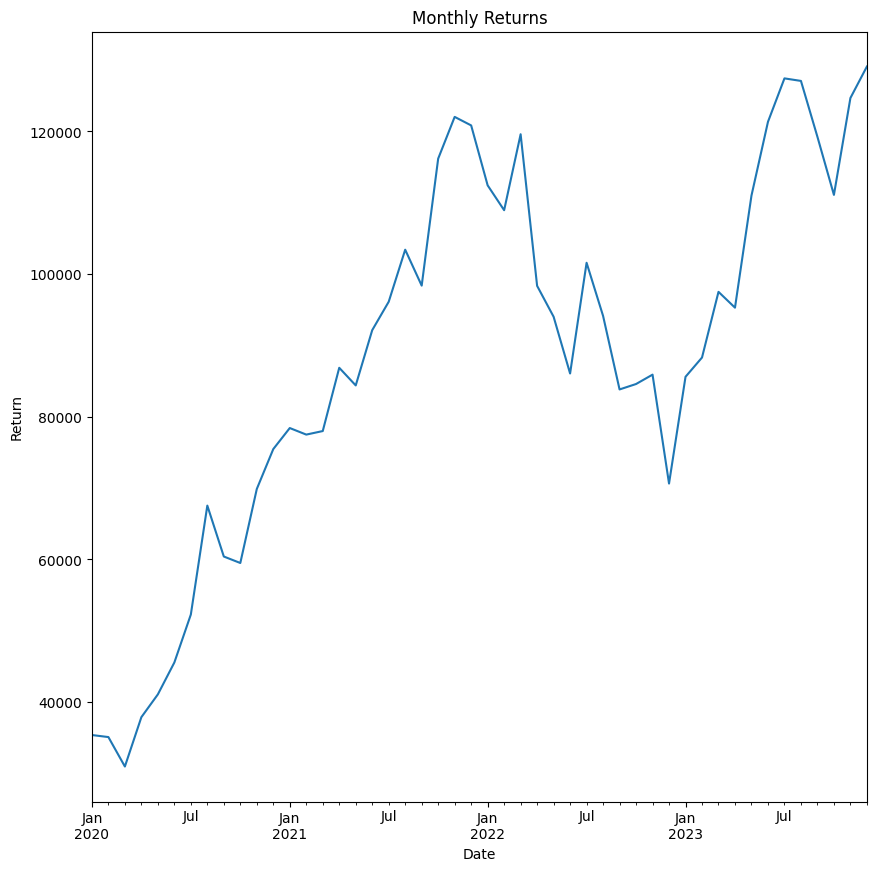

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import backtrader as bt

# Load data
data = pd.read_csv('stock_data_full.csv', index_col=0, parse_dates=True)

# Extract tickers
tickers = ['NVDA.US', 'TSLA.US', 'AAPL.US', 'GOOG.US']

# Set initial portfolio
initial_investment = 100000
portfolio = {
    ticker: initial_investment / len(tickers) / data[f'{ticker}_Close'][0]
    for ticker in tickers
}

def rebalance_portfolio(portfolio, prices, tickers):
    equal_weight = 1 / len(portfolio)
    for ticker in portfolio:
        current_value = portfolio[ticker] * prices[f'{ticker}_Close']
        target_value = equal_weight * sum(prices[f'{t}_Close'] * portfolio[t] for t in tickers)
        portfolio[ticker] = target_value / prices[f'{ticker}_Close']
    return portfolio

# Monthly rebalance
monthly_returns = []
for date, prices in data.resample('M').last().iterrows():
    portfolio = rebalance_portfolio(portfolio, prices, tickers)
    portfolio_value = sum(portfolio[ticker] * prices[f'{ticker}_Close'] for ticker in portfolio)
    monthly_returns.append(portfolio_value)

monthly_returns = pd.Series(monthly_returns, index=data.resample('M').last().index)

# Display results
print("月次リバランス後のポートフォリオ価値:")
print(monthly_returns)

# Display detailed results
print("\n月次リターン:")
monthly_pct_change = monthly_returns.pct_change().fillna(0)
monthly_pct_change_percentage = monthly_returns.pct_change().fillna(0) * 100
monthly_pct_change_percentage = monthly_pct_change_percentage.round(2)
monthly_pct_change_percentage = monthly_pct_change_percentage.apply(lambda x: '{:.2f}%'.format(x))
print(monthly_pct_change_percentage)

annual_returns = monthly_pct_change.groupby(monthly_pct_change.index.year).apply(lambda x: (1 + x).prod() - 1)
print("\n年次リターン:")
annual_returns_percentage = annual_returns.apply(lambda x: f"{x * 100:.2f}%")
annual_returns_percentage.index.freq = None
print(annual_returns_percentage.to_string(), end="\n\n")

#Sharp ratio
print("\nシャープレシオ:")
sharpe_ratio = np.mean(monthly_pct_change) / np.std(monthly_pct_change) * np.sqrt(12)
print(sharpe_ratio)

# Sortino ratio
print("\nソルティノレシオ:")
downside_deviation = monthly_pct_change[monthly_pct_change < 0].std()
sortino_ratio = np.mean(monthly_pct_change) / downside_deviation * np.sqrt(12)
print(sortino_ratio)

# Calmar ratio
annual_return = (1 + monthly_pct_change.mean()) ** 12 - 1
max_drawdown = (monthly_returns / monthly_returns.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)
print("\nカルマーレシオ:")
print(calmar_ratio)

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot monthly returns
monthly_returns.plot(ax=ax, title='Monthly Returns', ylabel='Return')

# Display plot
plt.show()